In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from math import sqrt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
pd.plotting.register_matplotlib_converters()
import seaborn as sns

In [2]:
df = pd.read_csv('total_sales_by_store_df.csv')

In [3]:
df.sale_date = df.sale_date.map(lambda x: str(x)[:-13])

In [4]:
df

,Unnamed: 0,sale_amount,sale_date,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
0,0,13.0,"Tue, 01 Jan 2013",1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
1,1,11.0,"Wed, 02 Jan 2013",2,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
2,2,14.0,"Thu, 03 Jan 2013",3,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
3,3,13.0,"Fri, 04 Jan 2013",4,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
4,4,10.0,"Sat, 05 Jan 2013",5,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912995,912995,63.0,"Wed, 27 Dec 2017",912996,8503 NW Military Hwy,San Antonio,10,TX,78231,Choice,50,Choice Organic Teas Black Tea Classic Black - ...,5.20,47445919221,47445919221
912996,912996,59.0,"Thu, 28 Dec 2017",912997,8503 NW Military Hwy,San Antonio,10,TX,78231,Choice,50,Choice Organic Teas Black Tea Classic Black - ...,5.20,47445919221,47445919221
912997,912997,74.0,"Fri, 29 Dec 2017",912998,8503 NW Military Hwy,San Antonio,10,TX,78231,Choice,50,Choice Organic Teas Black Tea Classic Black - ...,5.20,47445919221,47445919221
912998,912998,62.0,"Sat, 30 Dec 2017",912999,8503 NW Military Hwy,San Antonio,10,TX,78231,Choice,50,Choice Organic Teas Black Tea Classic Black - ...,5.20,47445919221,47445919221


In [5]:
def prep_data(df):
    return df.\
        assign(ds=pd.to_datetime(df.sale_date)).\
        sort_values('ds').\
        assign(y=df.sale_amount * df.item_price).\
        groupby(['ds'])['y'].sum().\
        reset_index().\
        set_index('ds')

In [6]:
df = prep_data(df)

In [7]:
df

,y
ds,
2013-01-01,73844.01
2013-01-02,73570.58
2013-01-03,78169.48
2013-01-04,84467.73
2013-01-05,87621.85
...,...
2017-12-27,109151.15
2017-12-28,117377.49
2017-12-29,126541.84


In [8]:
train = df[:'2015']

In [9]:
validate = df['2016']

In [10]:
test = df['2017']

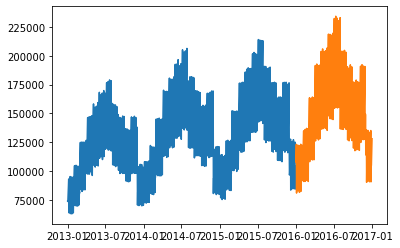

In [11]:
plt.plot(train)
plt.plot(validate)

In [12]:
train['cap'] = 250000
train['floor'] = 25000

# reset index as prophet needs ds to be a column and not an index. 
train = train.reset_index()
validate = validate.reset_index()
test = test.reset_index()

train.head(2)

,ds,y,cap,floor
0,2013-01-01,73844.01,250000,25000
1,2013-01-02,73570.58,250000,25000


In [33]:
m = Prophet(daily_seasonality = False,
            weekly_seasonality = True,
            growth = 'logistic',
            changepoint_range = 0.9)
m.add_country_holidays(country_name='US')
m.fit(train)

print(m.train_holiday_names)

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10    Independence Day (Observed)
dtype: object


In [14]:
future = m.make_future_dataframe(periods = len(validate))
future['cap'] = 250000
future['floor'] = 25000

In [15]:
pd.concat([future.head(2), future.tail(2)])

,ds,cap,floor
0,2013-01-01,250000,25000
1,2013-01-02,250000,25000
1459,2016-12-30,250000,25000
1460,2016-12-31,250000,25000


In [16]:
forecast = m.predict(future)

In [17]:
forecast.columns

Index(['ds', 'trend', 'cap', 'floor', 'yhat_lower', 'yhat_upper',
       'trend_lower', 'trend_upper', 'Christmas Day', 'Christmas Day_lower',
       'Christmas Day_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (Observed)',
       'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'Thanksgiving', 'Thanksgiving_lower', 'Thanksgiving_upper',
       'Veterans Day', 'Veterans Day_lower', 'Veterans Day_upper',
       'Washington's Birthday', 'Washington's Birthday_lower',
       'Washington's Birthday_upper', 'additive_terms', 'a

In [18]:
# select the dates for the holidays listed, and extract the sales predictions during those holidays
forecast[(forecast['Christmas Day'] + 
          forecast['Thanksgiving'] + 
          forecast["New Year's Day"]).abs() > 0]\
        [['ds', 
          'Christmas Day', 
          'Thanksgiving', 
          "New Year's Day"]][-10:]

,ds,Christmas Day,Thanksgiving,New Year's Day
358,2013-12-25,1488.959016,0.000000,0.000000
365,2014-01-01,0.000000,0.000000,1747.996731
695,2014-11-27,0.000000,14054.062047,0.000000
723,2014-12-25,1488.959016,0.000000,0.000000
730,2015-01-01,0.000000,0.000000,1747.996731
1059,2015-11-26,0.000000,14054.062047,0.000000
1088,2015-12-25,1488.959016,0.000000,0.000000
1095,2016-01-01,0.000000,0.000000,1747.996731
1423,2016-11-24,0.000000,14054.062047,0.000000
1454,2016-12-25,1488.959016,0.000000,0.000000


In [19]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1456,2016-12-27,105037.524918,97211.630552,113207.109707
1457,2016-12-28,105316.457126,97457.448259,113288.877668
1458,2016-12-29,113581.221586,106020.137563,121576.813656
1459,2016-12-30,122588.553978,114304.510591,131118.193647
1460,2016-12-31,131541.216544,123109.510383,140055.073698


In [20]:
from sklearn.metrics import mean_squared_error

In [21]:
eval_df = pd.merge(df, forecast[['ds', 'yhat']], how = 'inner', on = 'ds')

In [22]:
rmse = sqrt(mean_squared_error(eval_df.y, eval_df.yhat))
rmse

6509.141275424203

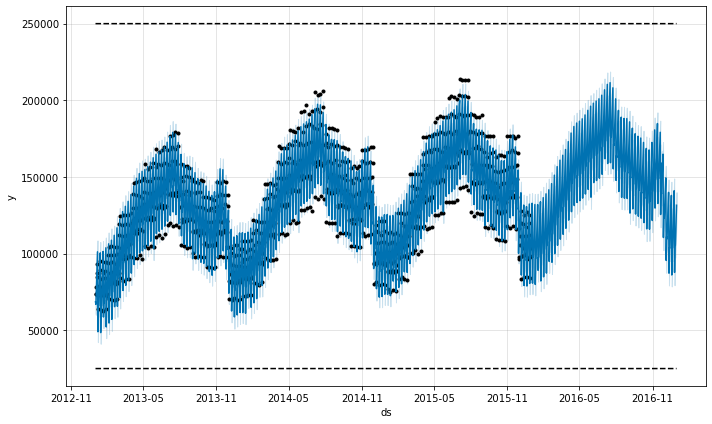

In [23]:
fig1 = m.plot(forecast)

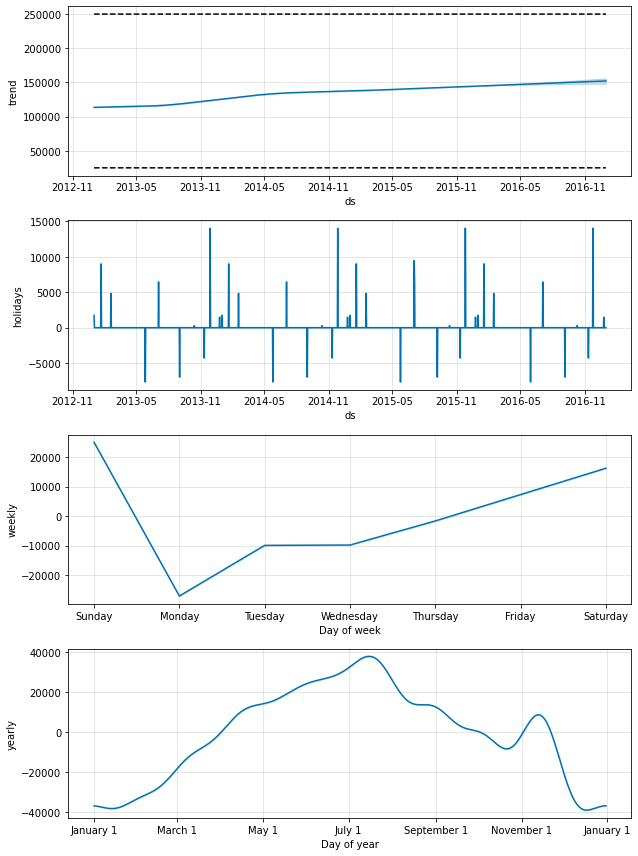

In [24]:
fig2 = m.plot_components(forecast, 'holidays')

In [25]:
# format for initial, period and horizon should be in format 
# used by pandas timedelta, which accepts units of days or shorter. 

df_cv = cross_validation(m, 
                         initial = '730 days', 
                         period = '90 days', 
                         horizon = '180 days', 
                        )
df_cv.head()

INFO:fbprophet:Making 3 forecasts with cutoffs between 2015-01-05 00:00:00 and 2015-07-04 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-06,94616.027318,87874.746357,101232.713491,88606.83,2015-01-05
1,2015-01-07,94618.749125,87565.364192,100910.754831,87704.19,2015-01-05
2,2015-01-08,102500.578904,95965.289605,108818.547332,94971.00,2015-01-05
3,2015-01-09,111125.653917,104397.794946,117664.222649,101312.99,2015-01-05
4,2015-01-10,120245.220562,113258.472203,126909.752076,106900.92,2015-01-05


In [26]:
df_cv.cutoff.value_counts()

2015-07-04    180
2015-04-05    180
2015-01-05    180
Name: cutoff, dtype: int64

In [27]:
df_p = performance_metrics(df_cv)
df_p.head(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,6.656100e+07,8158.492458,6880.351469,0.055557,0.043392,0.555556
1,19 days,6.615761e+07,8133.732693,6799.334987,0.055722,0.042449,0.555556
2,20 days,7.187106e+07,8477.679861,7024.798965,0.056953,0.042449,0.537037
3,21 days,7.485863e+07,8652.088359,7246.166126,0.058188,0.043178,0.518519
4,22 days,7.908077e+07,8892.737014,7450.578433,0.059467,0.043178,0.518519


In [28]:
df_p[df_p.horizon == "60 days"]

,horizon,mse,rmse,mae,mape,mdape,coverage
42,60 days,8.207198e+07,9059.358583,7291.151986,0.055031,0.041783,0.518519


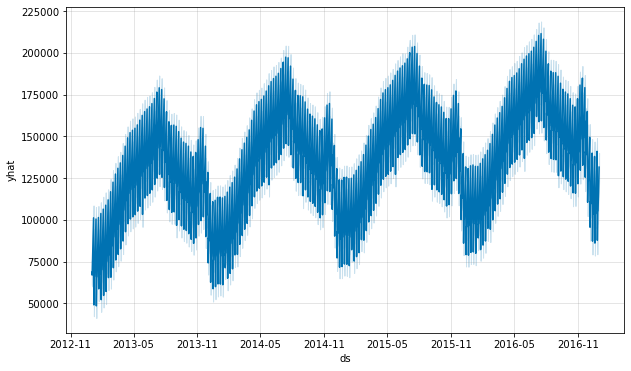

In [30]:
plot_forecast_component(m, forecast, 'yhat')
plt.show()

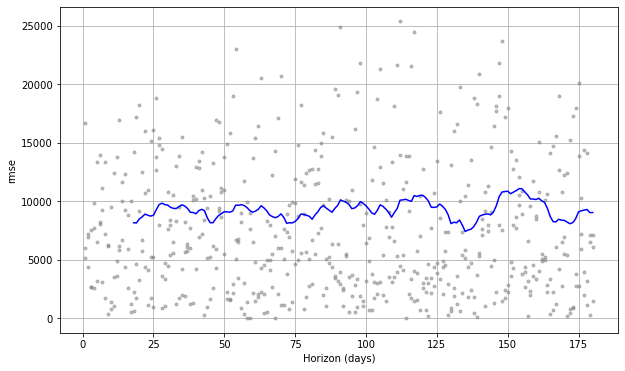

In [31]:
fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

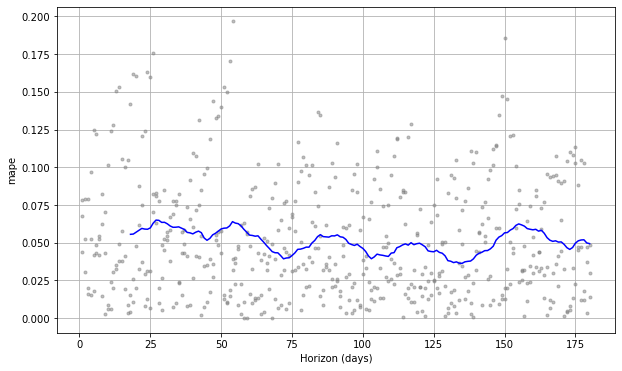

In [32]:
fig3 = plot_cross_validation_metric(df_cv, metric='mape')